# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

### Download data

In [ ]:
#!L
from gfile import download_list

download_list(
    url='https://drive.google.com/file/d/1F96x4LDbsTZGMMq81fZr7aduJCe8N95O',
    filename='celeba.zip',
    target_dir='.'
)

In [ ]:
#!L:bash
!unzip celeba.zip

## Prepare the data

In [10]:
#!L
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
device = torch.device("cuda")

In [12]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [13]:
#!L

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

In [14]:
#!L
# Save first 10k images for evaluation
num_images = 10000
real_images_tensor = torch.stack([train_dataset[i][0] for i in range(num_images)], dim=0)
real_images = real_images_tensor.data.numpy().transpose([0, 2, 3, 1])
np.savez("real.npz", Pictures=real_images.reshape(num_images, 64 * 64 * 1))

In [15]:
#!L
BATCH_SIZE = 256

# you may find useful parameters `num_workers` and `pin_memory`
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

In [16]:
#!L
dimZ = 100  # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(Reshape(-1, 64 * 64), 
                                     nn.Linear(64 * 64, 25 * dimZ), nn.ReLU(), 
                                     nn.Linear(25 * dimZ, dimZ))
        
        self.decoder = nn.Sequential(nn.Linear(dimZ, 25 * dimZ), nn.ReLU(), 
                                     nn.Linear(25 * dimZ, 64 * 64), nn.Sigmoid(), Reshape(-1, 1, 64, 64))
        
        self.init_bias()

    def forward(self, x):

        # DONE
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code
    
    def init_bias(self):
        self.encoder[1].bias.data.fill_(0)
        self.encoder[3].bias.data.fill_(0)
        
        self.decoder[0].bias.data.fill_(0)
        self.decoder[2].bias.data.fill_(0)

In [17]:
#!L
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [18]:
#!L
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
import tqdm

num_epoch = 20
train_losses = []
val_losses = []
for epoch in range(num_epoch):
    train_loss = []
    autoencoder.train()
    for x, _ in tqdm.tqdm(train_loader):
        x = x.to(device)
        rec, lat = autoencoder(x)
        loss = criterion(rec, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.cpu().data.numpy())
    train_losses.append(np.mean(train_loss))
    
    val_loss = []
    autoencoder.eval()
    with torch.no_grad():
        for x, _ in tqdm.tqdm(val_loader):
            x = x.to(device)
            rec, lat = autoencoder(x)
            loss = criterion(rec, x)
            val_loss.append(loss.cpu().data.numpy())
        val_losses.append(np.mean(val_loss))
            
    scheduler.step()
    print("Epoch %d: train loss = %.5f, val loss = %.5f" %(epoch+1, np.mean(train_loss), np.mean(val_loss)))  

100%|██████████| 78/78 [00:07<00:00,  9.92it/s]


Epoch 1: train loss = 0.01659, val loss = 0.00985


100%|██████████| 78/78 [00:08<00:00,  8.70it/s]


Epoch 2: train loss = 0.00796, val loss = 0.00687


100%|██████████| 78/78 [00:07<00:00, 10.59it/s]


Epoch 3: train loss = 0.00640, val loss = 0.00583


100%|██████████| 78/78 [00:07<00:00,  9.80it/s]


Epoch 4: train loss = 0.00564, val loss = 0.00536


100%|██████████| 78/78 [00:07<00:00, 10.48it/s]


Epoch 5: train loss = 0.00525, val loss = 0.00503


100%|██████████| 78/78 [00:08<00:00,  9.57it/s]


Epoch 6: train loss = 0.00476, val loss = 0.00472


100%|██████████| 78/78 [00:07<00:00, 10.48it/s]


Epoch 7: train loss = 0.00468, val loss = 0.00463


100%|██████████| 78/78 [00:08<00:00,  8.99it/s]


Epoch 8: train loss = 0.00463, val loss = 0.00461


100%|██████████| 78/78 [00:20<00:00,  3.82it/s]


Epoch 9: train loss = 0.00458, val loss = 0.00462


100%|██████████| 78/78 [00:17<00:00,  4.51it/s]


Epoch 10: train loss = 0.00453, val loss = 0.00454


100%|██████████| 78/78 [00:09<00:00,  8.61it/s]


Epoch 11: train loss = 0.00440, val loss = 0.00439


100%|██████████| 78/78 [00:07<00:00, 10.50it/s]


Epoch 12: train loss = 0.00438, val loss = 0.00438


100%|██████████| 78/78 [00:07<00:00,  9.81it/s]


Epoch 13: train loss = 0.00436, val loss = 0.00436


100%|██████████| 78/78 [00:08<00:00,  8.69it/s]


Epoch 14: train loss = 0.00434, val loss = 0.00434


100%|██████████| 78/78 [00:08<00:00,  9.38it/s]


Epoch 15: train loss = 0.00432, val loss = 0.00431


100%|██████████| 78/78 [00:08<00:00,  8.69it/s]


Epoch 16: train loss = 0.00425, val loss = 0.00426


100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Epoch 17: train loss = 0.00425, val loss = 0.00426


100%|██████████| 78/78 [00:07<00:00,  9.89it/s]


Epoch 18: train loss = 0.00424, val loss = 0.00424


100%|██████████| 78/78 [00:07<00:00,  9.75it/s]


Epoch 19: train loss = 0.00423, val loss = 0.00423


100%|██████████| 78/78 [00:07<00:00,  9.95it/s]

Epoch 20: train loss = 0.00422, val loss = 0.00422


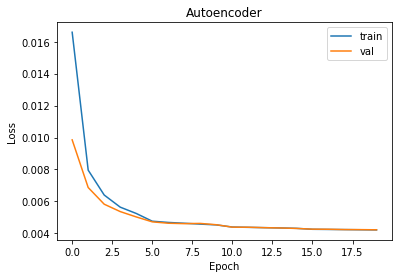

In [19]:
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(val_losses)), val_losses, label='val' )
 
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Autoencoder')
 
plt.legend()
plt.show()

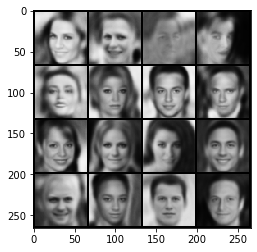

In [20]:
#!L
# Examine the reconstructions
from itertools import islice

images, _ = list(islice(val_loader, 1))[0]
reconstruction, latent_code = autoencoder(images.to(device))

reconstruction = reconstruction[:16].cpu()
plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

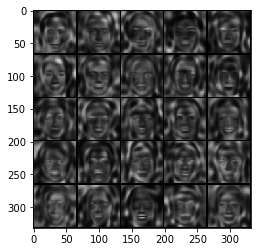

In [21]:
#!L
z = torch.randn(25, dimZ) * 0.5
reconstruction = autoencoder.decoder(z.to(device)).clamp(0, 1)

plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))

So, if we sample $z$ from normal, would we eventually generate all possible faces? What do you think?

Думаю, что скрытой размерности 100 более-менее хватит для генерации всех возможных лиц в данном разрешении.

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [22]:
#!L
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(64 * 64, 25 * dimZ)
        self.fc_mu = nn.Linear(25 * dimZ, dimZ)
        self.fc_logsigma = nn.Linear(25 * dimZ, dimZ)
        
        self.init_bias()
        
    def forward(self, x):
        x = x.view(-1, 64 * 64)
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc_mu(x), self.fc_logsigma(x)
    
    def init_bias(self):
        self.fc1.bias.data.fill_(0)
        self.fc_logsigma.bias.data.fill_(0)
        self.fc_mu.bias.data.fill_(0)

    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(dimZ, 25 * dimZ)
        self.fc_mu = nn.Linear(25 * dimZ, 64 * 64)
        self.fc_logsigma = nn.Linear(25 * dimZ, 64 * 64)
        
        self.init_bias()
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        mu = torch.sigmoid(self.fc_mu(x)).view(-1, 1, 64, 64)
        logsigma = self.fc_logsigma(x).view(-1, 1, 64, 64)
        return mu, logsigma
    
    def init_bias(self):
        self.fc1.bias.data.fill_(0)
        self.fc_logsigma.bias.data.fill_(0)
        self.fc_mu.bias.data.fill_(0)
        

class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def gaussian_sampler(self, mu, logsigma):
        noise = torch.randn_like(mu)
        return noise * logsigma.exp() + mu

    def forward(self, x):
        latent_mu, latent_logsigma = self.encoder(x)
        
        z = self.gaussian_sampler(latent_mu, latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decoder(z)
        
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z) \to max$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

logsigma лучше, так как нам не нужно думать, как сделать сигму положительной.

In [23]:
#!L
import math

def KL_divergence(mu, logsigma):
    return -0.5 * torch.mean(1 + 2 * logsigma - mu.pow(2) - logsigma.exp().pow(2))


def log_likelihood(x, mu, logsigma):
    return torch.mean(-0.5 * math.log(2 * math.pi) - logsigma - (mu - x).pow(2) / (2 * logsigma.exp().pow(2)))


def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return KL_divergence(mu_z, logsigma_z) - log_likelihood(x, mu_gen, logsigma_gen)

Поставил mean вместо sum в обеих компонентах лосса. Математически это не скажется на оптимизации, так как Adam инвариантен к скалированию функции (почти, так как в знаменателе эпсилон). Мне кажется, что так лучше, из-за того, что в случае sum лосс имеет гораздо больший масштаб, что скажется на градиентах. Я пробовал и так, и так, и с усреднением получилось лучше.

Константу в log_likelihood оставил, так как она ничего не портит.

And train the model:

In [24]:
#!L
# train your variational autoencoder
# visualize progress in reconstruction and loss decay

vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epoch = 20
train_losses = []
val_losses = []
for epoch in range(num_epoch):
    train_loss = []
    vae.train()
    for x, _ in tqdm.tqdm(train_loader):
        x = x.to(device)
        mu_gen, logsigma_gen, mu_z, logsigma_z = vae(x)
        
        loss = loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        assert not torch.isnan(loss.cpu().data)
        train_loss.append(loss.cpu().data.numpy())
    train_losses.append(np.mean(train_loss))
    
    val_loss = []
    vae.eval()
    with torch.no_grad():
        for x, _ in tqdm.tqdm(val_loader):
            x = x.to(device)
            mu_gen, logsigma_gen, mu_z, logsigma_z = vae(x)
            loss = loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z)
            val_loss.append(loss.cpu().data.numpy())
        
        val_losses.append(np.mean(val_loss))
            
    scheduler.step()
    print("Epoch %d: train loss = %.5f, val loss = %.5f" %(epoch+1, np.mean(train_loss), np.mean(val_loss)))  

100%|██████████| 78/78 [00:07<00:00,  9.83it/s]


Epoch 1: train loss = -0.14736, val loss = -0.25416


100%|██████████| 78/78 [00:08<00:00,  9.75it/s]


Epoch 2: train loss = -0.30244, val loss = -0.34668


100%|██████████| 78/78 [00:09<00:00,  8.52it/s]


Epoch 3: train loss = -0.39043, val loss = -0.42366


100%|██████████| 78/78 [00:08<00:00,  9.48it/s]


Epoch 4: train loss = -0.44121, val loss = -0.45684


100%|██████████| 78/78 [00:08<00:00,  8.79it/s]


Epoch 5: train loss = -0.47136, val loss = -0.48110


100%|██████████| 78/78 [00:08<00:00,  9.46it/s]


Epoch 6: train loss = -0.49562, val loss = -0.49962


100%|██████████| 78/78 [00:08<00:00,  9.10it/s]


Epoch 7: train loss = -0.50718, val loss = -0.50981


100%|██████████| 78/78 [00:09<00:00,  8.20it/s]


Epoch 8: train loss = -0.51714, val loss = -0.51938


100%|██████████| 78/78 [00:09<00:00,  8.39it/s]


Epoch 9: train loss = -0.52647, val loss = -0.52459


100%|██████████| 78/78 [00:09<00:00,  8.59it/s]


Epoch 10: train loss = -0.53563, val loss = -0.53635


100%|██████████| 78/78 [00:08<00:00,  9.11it/s]


Epoch 11: train loss = -0.54472, val loss = -0.54478


100%|██████████| 78/78 [00:08<00:00,  9.28it/s]


Epoch 12: train loss = -0.54858, val loss = -0.54813


100%|██████████| 78/78 [00:08<00:00,  9.63it/s]


Epoch 13: train loss = -0.55248, val loss = -0.54803


100%|██████████| 78/78 [00:08<00:00,  8.91it/s]


Epoch 14: train loss = -0.55623, val loss = -0.55244


100%|██████████| 78/78 [00:08<00:00,  9.67it/s]


Epoch 15: train loss = -0.55972, val loss = -0.55785


100%|██████████| 78/78 [00:10<00:00,  7.51it/s]


Epoch 16: train loss = -0.56391, val loss = -0.56174


100%|██████████| 78/78 [00:09<00:00,  7.83it/s]


Epoch 17: train loss = -0.56580, val loss = -0.56309


100%|██████████| 78/78 [00:09<00:00,  8.56it/s]


Epoch 18: train loss = -0.56714, val loss = -0.56538


100%|██████████| 78/78 [00:08<00:00,  8.76it/s]


Epoch 19: train loss = -0.56892, val loss = -0.56723


100%|██████████| 78/78 [00:09<00:00,  8.16it/s]

Epoch 20: train loss = -0.57042, val loss = -0.56820


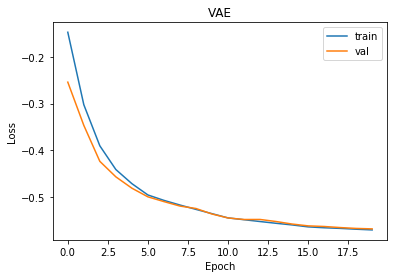

In [25]:
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(val_losses)), val_losses, label='val' )
 
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('VAE')
 
plt.legend()
plt.show()

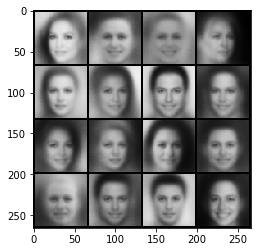

In [26]:
#!L
images, _ = list(islice(val_loader, 1))[0]
mu_gen, _, _, _ = vae(images.to(device))
reconstruction = mu_gen[:16].cpu().clamp(0, 1)

plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

And finally sample from VAE.

In [27]:
#!L
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

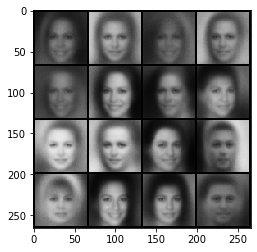

In [28]:
z = torch.randn(25, dimZ)
mu_gen, log_sigma = vae.decoder(z.to(device))
reconstruction = mu_gen[:16].clamp(0, 1).cpu().clamp(0, 1)

plt.imshow(make_grid(reconstruction.cpu(), nrow=4).permute(1, 2, 0))

Лучше, чем у автоэнкодера.

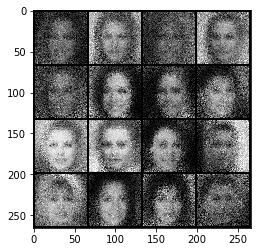

In [29]:
sample = mu_gen.cpu() + log_sigma.exp().cpu() * torch.randn(25, 1, 64, 64)
reconstruction = sample[:16].clamp(0, 1).cpu().clamp(0, 1)

plt.imshow(make_grid(reconstruction.cpu(), nrow=4).permute(1, 2, 0))

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column (index 31 of the attribute vector), but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">

In [31]:
images, attrs = list(islice(train_loader, 1))[0]
smiling = [i for i, at in enumerate(attrs) if at[31] == 1.0]
not_smiling = [i for i, at in enumerate(attrs) if at[31] == 0.0]

In [32]:
smiling_images = [images[s] for s in smiling]
not_smiling_images = [images[s] for s in not_smiling]

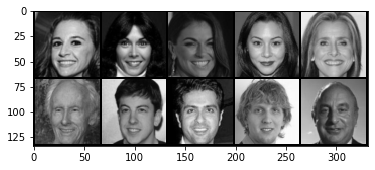

In [33]:
plt.imshow(make_grid(smiling_images[10:20], nrow=5).permute(1, 2, 0))

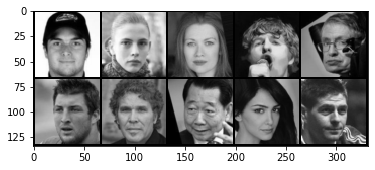

In [34]:
plt.imshow(make_grid(not_smiling_images[40:50], nrow=5).permute(1, 2, 0))

In [35]:
sm = torch.cat(smiling_images[10:20], dim=0).unsqueeze(dim=1)
nsm = torch.cat(not_smiling_images[40:50], dim=0).unsqueeze(dim=1)

In [36]:
with torch.no_grad():
    ae_latent_sm = autoencoder.encoder(sm.to(device))
    vae_latent_sm, _ = vae.encoder(sm.to(device))
    
    ae_latent_nsm = autoencoder.encoder(nsm.to(device))
    vae_latent_nsm, _ = vae.encoder(nsm.to(device))
    
    ae_smile_mean_diff = torch.mean(ae_latent_sm - ae_latent_nsm, dim=0)
    vae_smile_mean_diff = torch.mean(vae_latent_sm - vae_latent_nsm, dim=0)

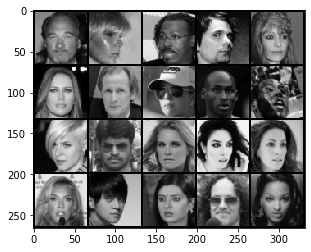

In [37]:
imgs = torch.cat(not_smiling_images[5:25], dim=0).unsqueeze(dim=1).to(device)
plt.imshow(make_grid(imgs.cpu().clamp(0, 1), nrow=5).permute(1, 2, 0))

До добавления вектора улыбки они (в основном) не улыбаются.

In [38]:
with torch.no_grad():
    ae_result = autoencoder.decoder(autoencoder.encoder(imgs) + ae_smile_mean_diff.unsqueeze(dim=0))
    vae_result, _ = vae.decoder(vae.encoder(imgs)[0] + vae_smile_mean_diff.unsqueeze(dim=0))

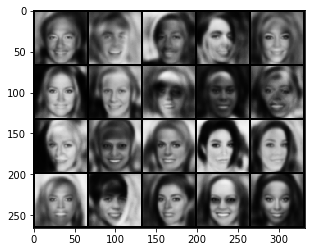

In [39]:
plt.imshow(make_grid(ae_result.cpu().clamp(0, 1), nrow=5).permute(1, 2, 0))

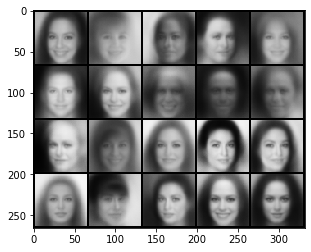

In [40]:
plt.imshow(make_grid(vae_result.cpu().clamp(0, 1), nrow=5).permute(1, 2, 0))